In [2]:
from __future__ import division
import pandas as pd
import numpy as np
from matplotlib.patches import Polygon
import matplotlib
from matplotlib.collections import PatchCollection
import mpl_toolkits
from mpl_toolkits.basemap import Basemap
from shapely.geometry import Point, Polygon, MultiPoint, MultiPolygon
from shapely.prepared import prep
from descartes import PolygonPatch
import matplotlib.pyplot as plt
from collections import defaultdict

% matplotlib inline

In [6]:
pd.options.display.max_columns = 999
pd.options.display.max_rows = 200

In [419]:
df=pd.read_csv('data/data_sample.csv')

In [7]:
df.head(4)

,Unnamed: 0,id,address,latitude,longitude,street,city,state,county,zip,bed,bath,price,sqft,created_at,updated_at,remarks,mls_num,prop_type,details,status,list_date,miles_ratio,lot_size,year_built,parking_spaces,garage,neighborhood,school_district,lonlat,mls,mls_status,mls_prop_type,pending_date,selling_date,selling_price
0,61493,62979,14424 6th Ave S,47.473534,-122.324989,6th,Burien,WA,King,98168.0,4.0,1.75,299800,2050,2016-03-21 15:11:11 -0700,2016-12-12 18:48:38 -0800,The right opportunity in a quiet neighborhood....,912436,Residential,"{""area""=>""130"", ""city""=>""Burien"", ""roof""=>""[\""...",cancelled,2016-03-21 00:00:00 -0700,1.0,10218.0,1959.0,1.0,True,Burien,Highline,POINT (-122.324989 47.473534),NWMLS,Cancelled,16 - 1 Story w/Bsmnt.,NaN,NaN,0
1,61239,62717,182 Huntingford St,48.077711,-122.869474,Huntingford,Port Townsend,WA,Jefferson,98368.0,3.0,2.00,299500,1726,2016-03-21 07:14:19 -0700,2016-11-16 10:34:27 -0800,"3 Bed 2 Bath, 1726 sq ft. Open and bright floo...",907601,Residential,"{""area""=>""482"", ""city""=>""Port Townsend"", ""roof...",sold,2016-03-21 00:00:00 -0700,1.0,18467.0,2005.0,2.0,True,Ocean Grove,Port Townsend,POINT (-122.869474 48.077711),NWMLS,Sold,NaN,2016-03-22,2016-05-23,315000
2,94941,127653,0 Lot 306 Trillium Rd,48.561758,-120.330388,Lot 306 Trillium,Winthrop,WA,Okanogan,98862.0,0.0,0.00,125000,0,2016-05-26 17:56:10 -0700,2017-02-01 15:01:24 -0800,Create your own private paradise on 2.8 acres ...,947565,Vacant Land,"{""gas""=>""Not Available"", ""sks""=>""true"", ""area""...",active,2016-05-26 00:00:00 -0700,1.0,121968.0,0.0,NaN,False,Edelweiss,Methow Valley,POINT (-120.330388 48.561758),NWMLS,Active,41 - Res-Over 1 Acre,NaN,NaN,0
3,53132,54405,356 Melissa St Camano Island WA 98282,48.223936,-122.528276,Melissa,Camano Island,WA,Island,98282.0,3.0,2.00,265000,1609,2016-03-09 14:33:40 -0800,2016-11-16 10:32:23 -0800,"1,600+ square foot north-end island home! Feat...",768562,Residential,"{""gas""=>nil, ""lgd""=>nil, ""sks""=>nil, ""area""=>""...",sold,2015-04-08 00:00:00 -0700,1.0,9600.0,1990.0,2.0,True,Madrona,Stanwood,POINT (-122.528276 48.223936),NWMLS,Sold,NaN,2016-03-09,2016-04-25,265000


In [8]:
def plot_prepper(m, shapefilename, df_key):
    '''
    Generate dataframe for plotting
    '''
    _out = m.readshapefile(shapefilename, name='seattle', drawbounds=False, color='none', zorder=2)
    # set up a map dataframe for neighborhood outlines
    cent_lons = [float((Polygon(points).centroid.wkt).split()[1][1:]) for points in m.seattle]
    cent_lats = [float((Polygon(points).centroid.wkt).strip(')').split()[2]) for points in m.seattle]

    df_poly = pd.DataFrame({
        'poly': [Polygon(points) for points in m.seattle],
        'name': [item[df_key] for item in m.seattle_info],
    })
    df_poly['centroid_1'] = cent_lons
    df_poly['centroid_2'] = cent_lats
    return _out, df_poly

### Read in neighborhood shape file

In [9]:
# Read in neighborhood shape file
hood_shapefilename = 'neighborhoods/WGS84/Neighborhoods'
hood_coords = (-122.43595589761988, 47.49551362397606, 
               -122.23604445458412, 47.73416494684497)

w, h = hood_coords[2] - hood_coords[0], hood_coords[3] - hood_coords[1]
extra = 0.005

0


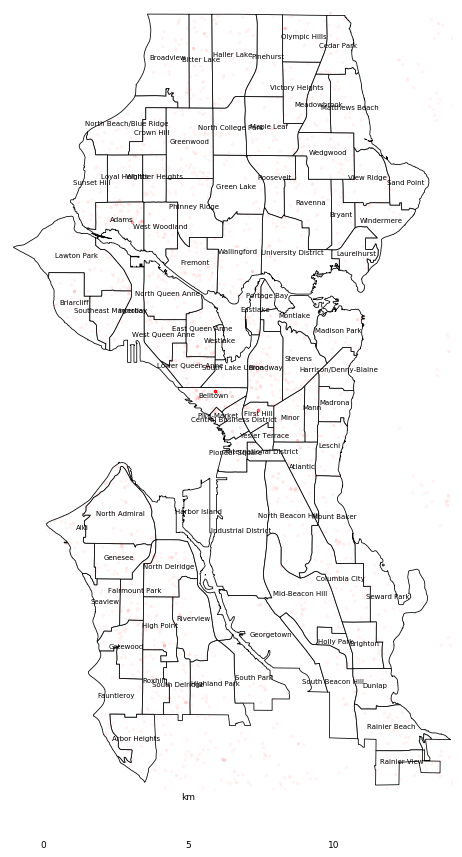

In [14]:
# Initialize the plot
figwidth = 12
fig = plt.figure(figsize=(figwidth, figwidth*h/w))
ax = fig.add_subplot(111, axisbg='w', frame_on=False)
m = Basemap(projection='tmerc', ellps='WGS84',
            lon_0=np.mean([hood_coords[0], hood_coords[2]]),
            lat_0=np.mean([hood_coords[1], hood_coords[3]]),
            llcrnrlon=hood_coords[0] - extra * w,
            llcrnrlat=hood_coords[1] - (extra * h),
            urcrnrlon=hood_coords[2] + extra * w,
            urcrnrlat=hood_coords[3] + (extra * h),
            resolution='i',  suppress_ticks=True)
# Get dataframe for plotting
_out, df_map = plot_prepper(m, hood_shapefilename, 'S_HOOD')
nbr_names = df_map['name'].unique()

# Draw neighborhoods with grey outlines
df_map['patches'] = df_map['poly'].map(lambda x: PolygonPatch(x, ec='#050505', lw=.8, alpha=1., zorder=4))
pc = PatchCollection(df_map['patches'], match_original=True)
pc.set_facecolor('w')
ax.add_collection(pc)

# Scale the map
m.drawmapscale(hood_coords[0] + 0.08, hood_coords[1] + -0.01, 
               hood_coords[0], hood_coords[1], 10., barstyle='fancy',
               fillcolor1='w', fillcolor2='#555555', zorder=5, ax=ax,)

lons = df.longitude
lats = df.latitude

pt = []
xs = []
ys = []

'''
This plots all the latitude/longitude points
'''
for mapped_x, mapped_y in zip(lons, lats):
    xpt, ypt = m(mapped_x, mapped_y)
    plt.plot(xpt, ypt, '.', markersize=5, alpha=0.03, color='r')
    pt.append(Point(xpt, ypt))
    xs.append(xpt)
    ys.append(ypt)

Labels = []
nmlist = []

'''
Checks the neighborhood of point
'''
# Creates list of neighborhoods
for polygon in df_map['poly']:
    nm = df_map.loc[df_map['poly'] == polygon, 'name'].iloc[0]
    if len(nm.strip()) < 4 or nm in nmlist:
        continue
    nmlist.append(nm)

"""
Determines neighborhood of point
"""
for i, p in enumerate(pt):
    # Create Unknown placeholder to capture points no in a neighborhood
    Labels.append('Unknown')
    # Tracks progress
    if i % 50000 == 0:
        print i
    # Creates polygon and if pt in polygon records neighborhood name
    for j, row in df_map.iterrows():
        polygon = row['poly']
        nm = row[0]
        if polygon.contains(p):
            Labels[i] = nm

# Add neighborhood names
nml = []
for i, lon in enumerate(df_map['centroid_1'].values):
    if df_map['name'].values[i] in nml:
        continue
    nml.append(df_map['name'].values[i])
    if len(df_map['name'].values[i]) > 3:
        plt.text(lon, df_map['centroid_2'].values[i], df_map['name'].values[i], size=7, ha='center')

ax.axes.get_xaxis().set_visible(False)
#plt.savefig('../images/seattle_911_neighborhoods.png')


In [46]:
len(Labels)

20003

In [47]:
df.shape

(20003, 37)

In [420]:
df['city_neighborhood'] = Labels

In [34]:
df[df['city_neighborhood']!='Unknown'][['neighborhood','city_neighborhood']].head(10)

,neighborhood,city_neighborhood
6,Bitter Lake,Bitter Lake
46,Phinney Ridge,Phinney Ridge
56,Central Area,Minor
73,Wallingford,Fremont
98,Queen Anne,West Queen Anne
103,Central Area,Minor
111,Belltown,Belltown
138,Bryant,Ravenna
165,Maple Leaf,Roosevelt
178,Columbia City,Columbia City


## Make sure to change  "North Beach/Blue Ridge' to North Beach / Blue Ridge and  "'Harrison/Denny-Blaine'' to 'Harrison / Denny-Blaine'

In [481]:
df=df[df['city_neighborhood']!='Unknown']

In [488]:
city1 = list(np.unique(df.city_neighborhood))
city1

['Adams',
 'Alki',
 'Arbor Heights',
 'Atlantic',
 'Belltown',
 'Bitter Lake',
 'Briarcliff',
 'Brighton',
 'Broadview',
 'Broadway',
 'Bryant',
 'Cedar Park',
 'Central Business District',
 'Columbia City',
 'Crown Hill',
 'Dunlap',
 'East Queen Anne',
 'Eastlake',
 'Fairmount Park',
 'Fauntleroy',
 'First Hill',
 'Fremont',
 'Gatewood',
 'Genesee',
 'Georgetown',
 'Green Lake',
 'Greenwood',
 'Haller Lake',
 'Harrison/Denny-Blaine',
 'High Point',
 'Highland Park',
 'Holly Park',
 'Interbay',
 'International District',
 'Laurelhurst',
 'Lawton Park',
 'Leschi',
 'Lower Queen Anne',
 'Loyal Heights',
 'Madison Park',
 'Madrona',
 'Mann',
 'Maple Leaf',
 'Matthews Beach',
 'Meadowbrook',
 'Mid-Beacon Hill',
 'Minor',
 'Montlake',
 'Mount Baker',
 'North Admiral',
 'North Beach/Blue Ridge',
 'North Beacon Hill',
 'North College Park',
 'North Delridge',
 'North Queen Anne',
 'Olympic Hills',
 'Phinney Ridge',
 'Pike-Market',
 'Pinehurst',
 'Pioneer Square',
 'Portage Bay',
 'Rainier Bea

In [489]:
city = ['Sunset Hill', 'Crown Hill', 'Greenwood', 'North College Park',
         'North Beach / Blue Ridge', 'Broadview', 'Bitter Lake',
         'Haller Lake', 'Loyal Heights', 'Adams', 'Whittier Heights',
         'West Woodland', 'Phinney Ridge', 'Wallingford', 'Fremont',
         'Green Lake','Pinehurst', 'Maple Leaf', 'Wedgwood', 'Matthews Beach',
         'Meadowbrook', 'Olympic Hills', 'Cedar Park', 'Victory Heights',
         'View Ridge', 'Ravenna', 'Sand Point', 'Bryant', 'Windermere',
         'Laurelhurst', 'Roosevelt', 'University District','West Queen Anne', 'North Queen Anne', 'Eastlake', 
         'Lawton Park', 'Briarcliff', 'Southeast Magnolia', 
         'Interbay', 'East Queen Anne','Montlake', 'Portage Bay', 'Madison Park', 'Broadway',
         'Stevens', 'Leschi', 'Madrona', 'Harrison / Denny-Blaine',
         'Minor', 'Mann', 'Atlantic', 'First Hill', 'Yesler Terrace','Pike-Market', 'International District', 
         'Central Business District', 'Pioneer Square','Belltown', 'Lower Queen Anne', 'Westlake', 'South Lake Union','Alki', 'North Admiral', 'Fairmount Park', 'Genesee',
         'Fauntleroy', 'North Delridge', 'Riverview', 'High Point',
         'South Delridge', 'Roxhill', 'Highland Park', 'Harbor Island',
         'South Park', 'Seaview', 'Gatewood', 'Arbor Heights','North Beacon Hill', 'Mid-Beacon Hill', 'South Beacon Hill',
         'Brighton', 'Dunlap', 'Rainier Beach', 'Rainier View',
         'Mount Baker', 'Columbia City', 'Seward Park', 'Georgetown',
         'Holly Park', 'Industrial District']

In [491]:
for i in city1:
    if i not in city:
        print i

Harrison/Denny-Blaine
North Beach/Blue Ridge


In [251]:
#city_n = sorted(zone)

In [252]:
street=[u'Alki',
 u'Arbor Heights',
 u'Atlantic',
 u'Ballard',
 u'Beacon Hill',
 u'Belltown',
 u'Briarcrest',
 u'Broadview Bitter Lake',
 u'Broadway (Capitol Hill)',
 u'Cedar Park / Meadowbrook',
 u'Columbia City',
 u'Downtown (Central Business District)',
 u'East Queen Anne',
 u'Eastlake',
 u'Fairmount Park',
 u'Fauntleroy',
 u'Fremont',
 u'Gatewood',
 u'Genesee',
 u'Georgetown',
 u'Green Lake',
 u'Haller Lake',
 u'Harbor Island',
 u'Harrison / Denny Blaine',
 u'High Point',
 u'Highland Park',
 u'Highland Terrace',
 u'Industrial District',
 u'Interbay',
 u'International District',
 u'Laurelhurst / Sand Point',
 u'Leschi',
 u'Licton Springs',
 u'Lower Queen Anne',
 u'Madison Park',
 u'Madrona',
 u'Magnolia',
 u'Mann',
 u'Minor',
 u'Montlake',
 u'Mount Baker',
 u'North Admiral',
 u'North Beach Blue Ridge',
 u'North Beacon Hill',
 u'North Delridge',
 u'North Queen Anne',
 u'Northgate',
 u'Olympic Hills / Victory Heights',
 u'Phinney Ridge / Greenwood',
 u'Pike Market',
 u'Pioneer Square',
 u'Portage Bay',
 u'Rainier Beach',
 u'Ravenna / Bryant',
 u'Riverview',
 u'Roxhill',
 u'Seaview',
 u'Seward Park',
 u'South Beacon Hill',
 u'South Delridge',
 u'South Lake Union',
 u'South Park',
 u'Stevens (Capitol Hill)',
 u'Sunset Hill',
 u'University District',
 u'Wallingford',
 u'Wedgeview Ridge',
 u'West Queen Anne',
 u'Westlake',
 u'Whittier Heights',
 u'Yesler Terrace']

In [ ]:
#s.translate(None, string.punctuation)

In [226]:
import string
punctuations_=set(string.punctuation)

In [253]:
# clean punctuations - turn this into punctuation
def remove_punctuations(input_list):
    '''
    remove punctuations from the given list of string
    input list of strings
    output list of strings
    '''
    n_list=[]
    for n in input_list:
        str_n=str(n)
        n_list.append(str_n.translate(None,string.punctuation))
    return n_list

In [254]:
street_clean=remove_punctuations(street)

In [258]:
city_clean=remove_punctuations(city)

In [259]:
city_clean

['Sunset Hill',
 'Crown Hill',
 'Greenwood',
 'North College Park',
 'North Beach  Blue Ridge',
 'Broadview',
 'Bitter Lake',
 'Haller Lake',
 'Loyal Heights',
 'Adams',
 'Whittier Heights',
 'West Woodland',
 'Phinney Ridge',
 'Wallingford',
 'Fremont',
 'Green Lake',
 'Pinehurst',
 'Maple Leaf',
 'Wedgwood',
 'Matthews Beach',
 'Meadowbrook',
 'Olympic Hills',
 'Cedar Park',
 'Victory Heights',
 'View Ridge',
 'Ravenna',
 'Sand Point',
 'Bryant',
 'Windermere',
 'Laurelhurst',
 'Roosevelt',
 'University District',
 'West Queen Anne',
 'North Queen Anne',
 'Eastlake',
 'Lawton Park',
 'Briarcliff',
 'Southeast Magnolia',
 'Interbay',
 'East Queen Anne',
 'Montlake',
 'Portage Bay',
 'Madison Park',
 'Broadway',
 'Stevens',
 'Leschi',
 'Madrona',
 'Harrison  DennyBlaine',
 'Minor',
 'Mann',
 'Atlantic',
 'First Hill',
 'Yesler Terrace',
 'PikeMarket',
 'International District',
 'Central Business District',
 'Pioneer Square',
 'Belltown',
 'Lower Queen Anne',
 'Westlake',
 'South Lake 

In [296]:
in_street_in_city={}
in_street_not_city=[]
for s in street_clean:
    if s not in city_clean:
        for c in city_clean:
            if s.split()[0] == c.split()[0]:
                if str(s) not in in_street_in_city:
                    in_street_in_city[str(s)] = set()
                in_street_in_city[str(s)].add(str(c))
            else:
                in_street_not_city.append(s)
#        in_street_not_city.append(n)

In [297]:
in_street_not_city_set=set(in_street_not_city)
mylist = list(in_street_not_city_set)
for key in in_street_in_city:
    if key in mylist:
        mylist.remove(key)

In [ ]:
# in street list but not in city list

In [298]:
mylist

['Ballard',
 'Magnolia',
 'Licton Springs',
 'Downtown Central Business District',
 'Wedgeview Ridge',
 'Beacon Hill',
 'Pike Market',
 'Briarcrest',
 'Northgate']

In [262]:
for key in in_street_in_city:
    if len(in_street_in_city[key]) > 1:
        for value in in_street_in_city[key]:
            if value.split()[1]==key.split()[1]:
                in_street_in_city[key]=value

In [263]:
in_street_in_city

{'Broadview Bitter Lake': {'Broadview'},
 'Broadway Capitol Hill': {'Broadway'},
 'Cedar Park  Meadowbrook': {'Cedar Park'},
 'Harrison  Denny Blaine': {'Harrison  DennyBlaine'},
 'Highland Terrace': {'Highland Park'},
 'Laurelhurst  Sand Point': {'Laurelhurst'},
 'North Beach Blue Ridge': 'North Beach  Blue Ridge',
 'Olympic Hills  Victory Heights': {'Olympic Hills'},
 'Phinney Ridge  Greenwood': {'Phinney Ridge'},
 'Ravenna  Bryant': {'Ravenna'},
 'Stevens Capitol Hill': {'Stevens'}}

In [281]:
for s in street:
    if '/' in list(s):
        print s

Cedar Park / Meadowbrook
Harrison / Denny Blaine
Laurelhurst / Sand Point
Olympic Hills / Victory Heights
Phinney Ridge / Greenwood
Ravenna / Bryant


In [282]:
for s in street:
    if '(' in list(s):
        print s

Broadway (Capitol Hill)
Downtown (Central Business District)
Stevens (Capitol Hill)


In [283]:
for c in city:
    if '/' in list(c):
        print c

North Beach / Blue Ridge
Harrison / Denny-Blaine


In [284]:
for c in city:
    if '(' in list(c):
        print c

In [285]:
## Based on this exploration ## manbuallly changed

In [310]:
# key street , value city , replace matching values in the city with the keys
street_city ={'Broadview / Bitter Lake': {'Broadview,Bitter Lake'},
 'Broadway (Capitol Hill)': {'Broadway'},
 'Cedar Park / Meadowbrook': {'Cedar Park, Meadowbrook'},
 'Harrison / Denny Blaine': {'Harrison/DennyBlaine'},
 'Highland Terrace': {'Highland Park'},
 'Laurelhurst / Sand Point': {'Laurelhurst,Sand Point','Windermere','View Ridge'},
 'North Beach Blue Ridge': 'North Beach/Blue Ridge',
 'Olympic Hills / Victory Heights': {'Olympic Hills,Victory Heights'},
 'Phinney Ridge / Greenwood': {'Phinney Ridge,Greenwood','Crown Hill'},
 'Ravenna / Bryant': {'Ravenna, Bryant','Roosevelt'}, # fix Bryantt to Bryant in street
 'Stevens (Capitol Hill)': {'Stevens'},
 'Downtown (Central Business District)':{'Central Business District','First Hill'},
 'Pike Market':{'PikeMarket'},
 'Ballard':{'West Woodland','Adams'},
 'Magnolia':{'Lawton Park','Briarcliff','Southeast Magnolia'},
 'Licton Springs':{'North College Park'},
 'Wedgeview Ridge':{'Wedgwood','Matthews Beach'},
 'Beacon Hill':{'Holly Park','Brighton','MidBeacon Hill'},
 'Rainier Beach':{'Rainier Beach','Rainier View','Dunlap'},
 'Northgate':{'Maple Leaf','Pinehurst'},
 'Sunset Hill':{'Seunset Hill','Loyal Heights'}
             }

In [ ]:
# In street but not in city
[#'Ballard',
 #'Magnolia',
 #'Licton Springs',
# 'Downtown Central Business District',
# 'Wedgeview Ridge',
# 'Beacon Hill',
# 'Pike Market',
 'Briarcrest', # not in the city neigb list
# 'Northgate']

In [ ]:
[#'Adams',
# 'Bitter Lake',
# 'Briarcliff',
# 'Brighton',
# 'Broadview',
# 'Broadway',
# 'Bryant',
# 'Cedar Park',
# 'Central Business District',
# 'Crown Hill',
# 'Dunlap',
# 'First Hill',
# 'Greenwood',
# 'Harrison  DennyBlaine',
# 'Holly Park',
# 'Laurelhurst',
# 'Lawton Park',
# 'Loyal Heights',
# 'Maple Leaf',
# 'Matthews Beach',
# 'Meadowbrook',
# 'MidBeacon Hill',
# 'North Beach  Blue Ridge',
# 'North College Park',
# 'Olympic Hills',
# 'Phinney Ridge',
# 'PikeMarket',
# 'Pinehurst',
# 'Rainier View', # Rainier Beach
# 'Ravenna',
# 'Roosevelt',
# 'Sand Point',
# 'Southeast Magnolia',
# 'Stevens',
# 'Victory Heights',
# 'View Ridge', # maybe in  'Wedgeview Ridge'
# 'Wedgwood',
# 'West Woodland',
# 'Windermere']

In [267]:
set(in_street_not_city)

{'Ballard',
 'Beacon Hill',
 'Briarcrest',
 'Broadview Bitter Lake',
 'Broadway Capitol Hill',
 'Cedar Park  Meadowbrook',
 'Downtown Central Business District',
 'Harrison  Denny Blaine',
 'Highland Terrace',
 'Laurelhurst  Sand Point',
 'Licton Springs',
 'Magnolia',
 'North Beach Blue Ridge',
 'Northgate',
 'Olympic Hills  Victory Heights',
 'Phinney Ridge  Greenwood',
 'Pike Market',
 'Ravenna  Bryant',
 'Stevens Capitol Hill',
 'Wedgeview Ridge'}

In [301]:
in_city_in_street={}
in_city_not_street=[]
for c in city_clean:
    if c not in street_clean:
        for s in street_clean:
            if c.split()[0] == s.split()[0]:
                if str(c) not in in_city_in_street:
                    in_city_in_street[str(c)] = set()
                in_city_in_street[str(c)].add(str(s))
            else:
                in_city_not_street.append(c)
#        in_street_not_city.append(n)

In [302]:
in_city_in_street

{'Broadview': {'Broadview Bitter Lake'},
 'Broadway': {'Broadway Capitol Hill'},
 'Cedar Park': {'Cedar Park  Meadowbrook'},
 'Harrison  DennyBlaine': {'Harrison  Denny Blaine'},
 'Laurelhurst': {'Laurelhurst  Sand Point'},
 'North Beach  Blue Ridge': {'North Admiral',
  'North Beach Blue Ridge',
  'North Beacon Hill',
  'North Delridge',
  'North Queen Anne'},
 'North College Park': {'North Admiral',
  'North Beach Blue Ridge',
  'North Beacon Hill',
  'North Delridge',
  'North Queen Anne'},
 'Olympic Hills': {'Olympic Hills  Victory Heights'},
 'Phinney Ridge': {'Phinney Ridge  Greenwood'},
 'Rainier View': {'Rainier Beach'},
 'Ravenna': {'Ravenna  Bryant'},
 'Stevens': {'Stevens Capitol Hill'},
 'West Woodland': {'West Queen Anne'}}

In [303]:
for key in in_city_in_street:
    if len(in_city_in_street[key]) > 1:
        for value in in_city_in_street[key]:
            if value.split()[1]==key.split()[1]:
                in_city_in_street[key]=value

In [304]:
in_city_in_street

{'Broadview': {'Broadview Bitter Lake'},
 'Broadway': {'Broadway Capitol Hill'},
 'Cedar Park': {'Cedar Park  Meadowbrook'},
 'Harrison  DennyBlaine': {'Harrison  Denny Blaine'},
 'Laurelhurst': {'Laurelhurst  Sand Point'},
 'North Beach  Blue Ridge': 'North Beach Blue Ridge',
 'North College Park': {'North Admiral',
  'North Beach Blue Ridge',
  'North Beacon Hill',
  'North Delridge',
  'North Queen Anne'},
 'Olympic Hills': {'Olympic Hills  Victory Heights'},
 'Phinney Ridge': {'Phinney Ridge  Greenwood'},
 'Rainier View': {'Rainier Beach'},
 'Ravenna': {'Ravenna  Bryant'},
 'Stevens': {'Stevens Capitol Hill'},
 'West Woodland': {'West Queen Anne'}}

In [305]:
set(in_city_not_street)

{'Adams',
 'Bitter Lake',
 'Briarcliff',
 'Brighton',
 'Broadview',
 'Broadway',
 'Bryant',
 'Cedar Park',
 'Central Business District',
 'Crown Hill',
 'Dunlap',
 'First Hill',
 'Greenwood',
 'Harrison  DennyBlaine',
 'Holly Park',
 'Laurelhurst',
 'Lawton Park',
 'Loyal Heights',
 'Maple Leaf',
 'Matthews Beach',
 'Meadowbrook',
 'MidBeacon Hill',
 'North Beach  Blue Ridge',
 'North College Park',
 'Olympic Hills',
 'Phinney Ridge',
 'PikeMarket',
 'Pinehurst',
 'Rainier View',
 'Ravenna',
 'Roosevelt',
 'Sand Point',
 'Southeast Magnolia',
 'Stevens',
 'Victory Heights',
 'View Ridge',
 'Wedgwood',
 'West Woodland',
 'Windermere'}

In [306]:
in_city_not_street_set=set(in_city_not_street)
mylist_ = list(in_city_not_street_set)
for key in in_city_in_street:
    if key in mylist_:
        mylist_.remove(key)

In [308]:
 sorted(mylist_1)

['Adams',
 'Bitter Lake',
 'Briarcliff',
 'Brighton',
 'Broadview',
 'Broadway',
 'Bryant',
 'Cedar Park',
 'Central Business District',
 'Crown Hill',
 'Dunlap',
 'First Hill',
 'Greenwood',
 'Harrison  DennyBlaine',
 'Holly Park',
 'Laurelhurst',
 'Lawton Park',
 'Loyal Heights',
 'Maple Leaf',
 'Matthews Beach',
 'Meadowbrook',
 'MidBeacon Hill',
 'North Beach  Blue Ridge',
 'North College Park',
 'Olympic Hills',
 'Phinney Ridge',
 'PikeMarket',
 'Pinehurst',
 'Rainier View',
 'Ravenna',
 'Roosevelt',
 'Sand Point',
 'Southeast Magnolia',
 'Stevens',
 'Victory Heights',
 'View Ridge',
 'Wedgwood',
 'West Woodland',
 'Windermere']

In [349]:
# key street , value city , replace matching values in the city with the keys
street_city ={'Broadview / Bitter Lake': ['Broadview,Bitter Lake'],
 'Broadway (Capitol Hill)': ['Broadway'],
 'Cedar Park / Meadowbrook': ['Cedar Park, Meadowbrook'],
 'Harrison / Denny Blaine': ['Harrison/DennyBlaine'],
 'Highland Terrace': ['Highland Park'],
 'Laurelhurst / Sand Point': ['Laurelhurst,Sand Point','Windermere','View Ridge'],
 'North Beach Blue Ridge': ['North Beach/Blue Ridge'],
 'Olympic Hills / Victory Heights': ['Olympic Hills,Victory Heights'],
 'Phinney Ridge / Greenwood': ['Phinney Ridge,Greenwood','Crown Hill'],
 'Ravenna / Bryant': ['Ravenna, Bryant','Roosevelt'],
 'Stevens (Capitol Hill)': ['Stevens'],
 'Downtown (Central Business District)':['Central Business District','First Hill'],
 'Pike Market':['PikeMarket'],
 'Ballard':['West Woodland','Adams'],
 'Magnolia':['Lawton Park','Briarcliff','Southeast Magnolia'],
 'Licton Springs':['North College Park'],
 'Wedgeview Ridge':['Wedgwood','Matthews Beach'],
 'Beacon Hill':['Holly Park','Brighton','MidBeacon Hill'],
 'Rainier Beach':['Rainier Beach','Rainier View','Dunlap'],
 'Northgate':['Maple Leaf','Pinehurst'],
 'Sunset Hill':['Seunset Hill','Loyal Heights']
             }

In [350]:
street_city_dict=street_city 
for n in street:
    if n not in street_city:
        street_city_dict[str(n)]=[str(n)]

In [351]:
len(street_city_dict)

72

In [356]:
city_street_dict={}
for key,value in street_city_dict.iteritems():
    if len(value)>1:
        for v in value:
            city_street_dict[v]=key
    else:
        city_street_dict[value[0]]=key

### city_street_dict : city vs street advisor neighborhood dictionary

In [360]:
len(city_street_dict)

86

In [512]:
for i in city1 :
    if i not in city_street_dict.keys():
        print i

In [511]:
city_street_dict = {'Adams': 'Ballard',
 'Alki': 'Alki',
 'Arbor Heights': 'Arbor Heights',
 'Atlantic': 'Atlantic',
 'Belltown': 'Belltown',
 'Briarcliff': 'Magnolia',
 'Briarcrest': 'Briarcrest',
 'Brighton': 'Beacon Hill',
 'Broadview Bitter Lake': 'Broadview Bitter Lake',
 'Broadview': 'Broadview / Bitter Lake',
 'Bitter Lake': 'Broadview / Bitter Lake',
 'Broadway': 'Broadway (Capitol Hill)',
 'Cedar Park': 'Cedar Park / Meadowbrook',
 'Meadowbrook': 'Cedar Park / Meadowbrook',
 'Central Business District': 'Downtown (Central Business District)',
 'Columbia City': 'Columbia City',
 'Crown Hill': 'Phinney Ridge / Greenwood',
 'Dunlap': 'Rainier Beach',
 'East Queen Anne': 'East Queen Anne',
 'Eastlake': 'Eastlake',
 'Fairmount Park': 'Fairmount Park',
 'Fauntleroy': 'Fauntleroy',
 'First Hill': 'Downtown (Central Business District)',
 'Fremont': 'Fremont',
 'Gatewood': 'Gatewood',
 'Genesee': 'Genesee',
 'Georgetown': 'Georgetown',
 'Green Lake': 'Green Lake',
 'Haller Lake': 'Haller Lake',
 'Harbor Island': 'Harbor Island',
 'Harrison/Denny-Blaine': 'Harrison / Denny Blaine',
 'High Point': 'High Point',
 'Highland Park': 'Highland Park',
 'Holly Park': 'Beacon Hill',
 'Industrial District': 'Industrial District',
 'Interbay': 'Interbay',
 'International District': 'International District',
 'Laurelhurst': 'Laurelhurst / Sand Point',
 'Sand Point': 'Laurelhurst / Sand Point',
 'Lawton Park': 'Magnolia',
 'Leschi': 'Leschi',
 'Lower Queen Anne': 'Lower Queen Anne',
 'Loyal Heights': 'Sunset Hill',
 'Madison Park': 'Madison Park',
 'Madrona': 'Madrona',
 'Mann': 'Mann',
 'Maple Leaf': 'Northgate',
 'Matthews Beach': 'Wedgeview Ridge',
 'Mid-Beacon Hill': 'Beacon Hill',
 'Minor': 'Minor',
 'Montlake': 'Montlake',
 'Mount Baker': 'Mount Baker',
 'North Admiral': 'North Admiral',
 'North Beach/Blue Ridge': 'North Beach Blue Ridge',
 'North Beacon Hill': 'North Beacon Hill',
 'North College Park': 'Licton Springs',
 'North Delridge': 'North Delridge',
 'North Queen Anne': 'North Queen Anne',
 'Olympic Hills': 'Olympic Hills / Victory Heights',
 'Victory Heights': 'Olympic Hills / Victory Heights',
 'Phinney Ridge': 'Phinney Ridge / Greenwood',
 'Greenwood': 'Phinney Ridge / Greenwood',
 'Pike-Market': 'Pike Market',
 'Pinehurst': 'Northgate',
 'Pioneer Square': 'Pioneer Square',
 'Portage Bay': 'Portage Bay',
 'Rainier Beach': 'Rainier Beach',
 'Rainier View': 'Rainier Beach',
 'Ravenna': 'Ravenna / Bryant',
 'Bryant': 'Ravenna / Bryant',
 'Riverview': 'Riverview',
 'Roosevelt': 'Ravenna / Bryant',
 'Roxhill': 'Roxhill',
 'Seaview': 'Seaview',
 'Sunset Hill': 'Sunset Hill',
 'Seward Park': 'Seward Park',
 'South Beacon Hill': 'South Beacon Hill',
 'South Delridge': 'South Delridge',
 'South Lake Union': 'South Lake Union',
 'South Park': 'South Park',
 'Southeast Magnolia': 'Magnolia',
 'Stevens': 'Stevens (Capitol Hill)',
 'University District': 'University District',
 'View Ridge': 'Laurelhurst / Sand Point',
 'Wallingford': 'Wallingford',
 'Wedgwood': 'Wedgeview Ridge',
 'West Queen Anne': 'West Queen Anne',
 'West Woodland': 'Ballard',
 'Westlake': 'Westlake',
 'Whittier Heights': 'Whittier Heights',
 'Windermere': 'Laurelhurst / Sand Point',
 'Yesler Terrace': 'Yesler Terrace'}

In [ ]:
df.drop(['Unnamed: 0'], axis=1, inplace=True)

In [515]:
# add street_neighborhood column based on city_neighborhood list
df['street_neighborhood']=df['city_neighborhood'].apply(lambda x : city_street_dict[x])

In [518]:
# Reset the index
df.reset_index(drop=True,inplace=True)

In [522]:
df.to_csv('data/data_seattle.csv')

In [521]:
df.head(5)

,id,address,latitude,longitude,street,city,state,county,zip,bed,bath,price,sqft,created_at,updated_at,remarks,mls_num,prop_type,details,status,list_date,miles_ratio,lot_size,year_built,parking_spaces,garage,neighborhood,school_district,lonlat,mls,mls_status,mls_prop_type,pending_date,selling_date,selling_price,city_neighborhood,street_neighborhood
0,5632,903 N 130th St Unit #317,47.722939,-122.347847,130th,Seattle,WA,King,98133.0,1.0,1.00,170000,619,2015-10-08 11:03:05 -0700,2017-02-27 01:34:03 -0800,This condo at The Courtyard at Bitter Lake is ...,857194,Condominium,"{""area""=>""705"", ""city""=>""Seattle"", ""roof""=>""[\...",sold,2015-10-08 00:00:00 -0700,1.0,13388.0,1989.0,1.0,False,Bitter Lake,Seattle,POINT (-122.347847 47.722939),NWMLS,Sold,32 - Townhouse,2015-10-16,2015-10-30,165000,Bitter Lake,Broadview / Bitter Lake
1,199838,156 NW 65th St,47.676205,-122.358856,65th,Seattle,WA,King,98117.0,3.0,1.75,795000,2180,2016-06-15 01:00:26 -0700,2016-11-16 11:41:30 -0800,"Fabulous 3+ bdrm, 1.75 bth Craftsman on Phinne...",943599,Residential,"{""area""=>""705"", ""city""=>""Seattle"", ""roof""=>""[\...",sold,2016-06-14 00:00:00 -0700,1.0,5000.0,1910.0,1.0,True,Phinney Ridge,Seattle,POINT (-122.358856 47.676205),NWMLS,Sold,16 - 1 Story w/Bsmnt.,2016-06-22,2016-08-19,875000,Phinney Ridge,Phinney Ridge / Greenwood
2,10252,120 20th Ave Seattle WA 98122,47.602303,-122.305954,20th,Seattle,WA,King,98122.0,3.0,1.75,619950,1511,2015-10-18 07:22:12 -0700,2016-11-16 09:51:21 -0800,Vida is an urban village of 15 rowhomes in a w...,860632,Residential,"{""gas""=>nil, ""lgd""=>nil, ""sks""=>nil, ""area""=>""...",sold,2015-10-16 00:00:00 -0700,1.0,1545.0,2015.0,1.0,True,Central Area,Seattle,POINT (-122.305954 47.602303),NWMLS,Sold,NaN,2015-10-24,2016-04-06,619950,Minor,Minor
3,12393,1102 N 41st St,47.656784,-122.344376,41st,Seattle,WA,King,98103.0,2.0,1.00,595595,1480,2015-11-06 09:18:15 -0800,2017-02-22 01:24:28 -0800,Corner lot! Cute house Wallingford/Fremont are...,867701,Residential,"{""area""=>""705"", ""city""=>""Seattle"", ""roof""=>""[\...",sold,2015-11-06 00:00:00 -0800,1.0,2680.0,1946.0,1.0,True,Wallingford,Seattle,POINT (-122.344376 47.656784),NWMLS,Sold,16 - 1 Story w/Bsmnt.,2015-11-13,2015-12-16,575000,Fremont,Fremont
4,7421,1927 W 8th Ave Seattle WA 98119,47.636703,-122.368057,8th,Seattle,WA,King,98119.0,2.0,1.75,829950,1490,2015-10-13 13:59:17 -0700,2016-11-16 09:45:23 -0800,A limited collection of 3 bedroom single famil...,816150,Residential,"{""gas""=>nil, ""lgd""=>nil, ""sks""=>nil, ""area""=>""...",sold,2015-07-08 00:00:00 -0700,1.0,1727.0,2015.0,1.0,True,Queen Anne,Seattle,POINT (-122.368057 47.636703),NWMLS,Sold,NaN,2015-07-08,2016-02-05,829950,West Queen Anne,West Queen Anne


# add matching street neighborhoods column, I will come back to this later

In [367]:
df.head(0)

,Unnamed: 0,id,address,latitude,longitude,street,city,state,county,zip,bed,bath,price,sqft,created_at,updated_at,remarks,mls_num,prop_type,details,status,list_date,miles_ratio,lot_size,year_built,parking_spaces,garage,neighborhood,school_district,lonlat,mls,mls_status,mls_prop_type,pending_date,selling_date,selling_price,city_neighborhood


In [421]:
df.drop(['Unnamed: 0'], axis=1, inplace=True)

In [422]:
df.shape

(20003, 36)

In [430]:
dfmap=df[df['city_neighborhood']!='Unknown']

In [431]:
dfmap.shape

(1834, 36)

In [ ]:
# Compare and check zip codes with the zip codes

In [400]:
zipcodes=[98101, 98102, 98103, 98104, 98105, 98106, 98107, 98108,98109,
          98110, 98112, 98115, 98116, 98117, 98118, 98119,98121, 98122,
          98125, 98126, 98131, 98133, 98134, 98136, 98144, 98146, 98148,
          98154, 98155, 98158, 98161, 98164, 98166, 98168, 98174, 98177,
          98178, 98188, 98198, 98199]

In [409]:
len(zipcodes)

40

In [ ]:
map(float,zipcodes)

In [398]:
df['zip'].values

array([ 98168.,  98368.,  98862., ...,  98802.,  98075.,  98034.])

In [414]:
b = set(df[df['zip'].isin(map(float,zipcodes))]['zip'].values)

In [415]:
a = set(np.unique(df['zip'].values))&set(map(float,zipcodes))

In [416]:
a == b

True

In [434]:
dfmap[dfmap['zip'].isin(map(float,zipcodes))].shape

(1832, 36)

In [462]:
#dfmap.head(3)

In [424]:
dfzip=df[df['zip'].isin(map(float,zipcodes))]

In [451]:
dfzip_vs_map = dfzip[np.logical_not(dfzip['id'].isin(dfmap['id']))]

In [459]:
#dfzip_vs_map[dfzip_vs_map['neighborhood'].isin(map(str,street))]

In [460]:
#dfzip_vs_map[dfzip_vs_map['neighborhood'].isin(city)]

In [461]:
#dfzip.head(3)

In [432]:
dfzip.shape

(2605, 36)